In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


## Load Data (Upload CSV)

In [2]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0], encoding='latin-1')
print(f"✓ Loaded: {df.shape}")

Saving data.csv to data.csv
✓ Loaded: (435742, 13)


In [3]:
r = 102317143
ar = 0.5 * (r % 7)
br = 0.3 * (r % 5 + 1)

print(f"ar = {ar}, br = {br}")

x = df['no2'].dropna().values[:50000]
z = x + ar * np.sin(br * x)

z_norm = 2 * (z - z.min()) / (z.max() - z.min()) - 1
z_tensor = torch.FloatTensor(z_norm).reshape(-1, 1)

print(f"✓ Using {len(z)} samples (FAST MODE)")

ar = 2.5, br = 1.2
✓ Using 50000 samples (FAST MODE)


In [4]:
class SimpleGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(50, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Tanh()
        )
    def forward(self, x):
        return self.net(x)

class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

G = SimpleGenerator().to(device)
D = SimpleDiscriminator().to(device)

opt_G = optim.Adam(G.parameters(), lr=0.0002)
opt_D = optim.Adam(D.parameters(), lr=0.0002)
loss_fn = nn.BCELoss()

print("✓ Models created")

✓ Models created


In [5]:
epochs = 100
batch_size = 512
z_data = z_tensor.to(device)

G_losses = []
D_losses = []

print("Starting training...")

for epoch in tqdm(range(epochs)):
    idx = torch.randperm(len(z_data))[:batch_size]
    real = z_data[idx]

    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    noise = torch.randn(batch_size, 50).to(device)
    fake = G(noise)

    opt_D.zero_grad()
    d_real = D(real)
    d_fake = D(fake.detach())
    d_loss = loss_fn(d_real, real_labels) + loss_fn(d_fake, fake_labels)
    d_loss.backward()
    opt_D.step()

    opt_G.zero_grad()
    fake = G(noise)
    g_loss = loss_fn(D(fake), real_labels)
    g_loss.backward()
    opt_G.step()

    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())

print("✓ Training done!")

Starting training...


100%|██████████| 100/100 [00:01<00:00, 57.60it/s]

✓ Training done!


In [6]:
G.eval()

with torch.no_grad():
    noise = torch.randn(10000, 50).to(device)
    fake_samples = G(noise).cpu().numpy().flatten()

z_fake = fake_samples * (z.max() - z.min()) / 2 + (z.max() + z.min()) / 2

print(f"Generated {len(z_fake)} samples")

Generated 10000 samples


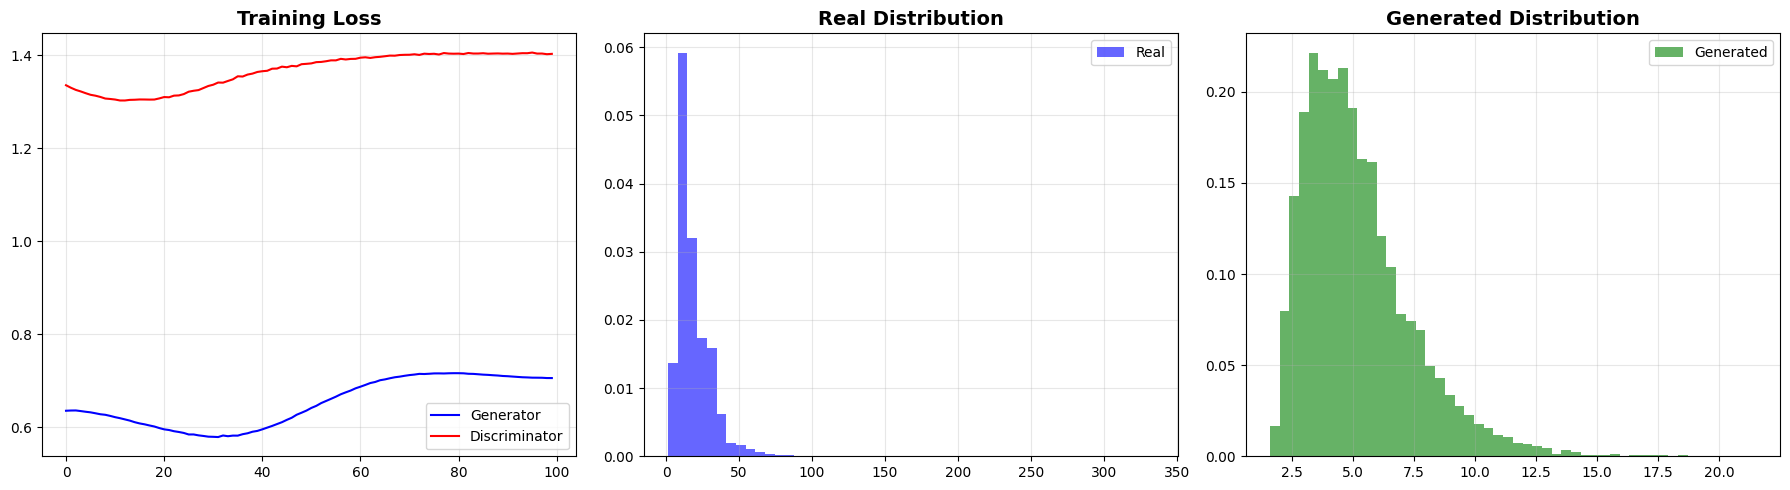

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(G_losses, 'b-', label='Generator')
axes[0].plot(D_losses, 'r-', label='Discriminator')
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(z, bins=50, density=True, alpha=0.6, color='blue', label='Real')
axes[1].set_title('Real Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].hist(z_fake, bins=50, density=True, alpha=0.6, color='green', label='Generated')
axes[2].set_title('Generated Distribution', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

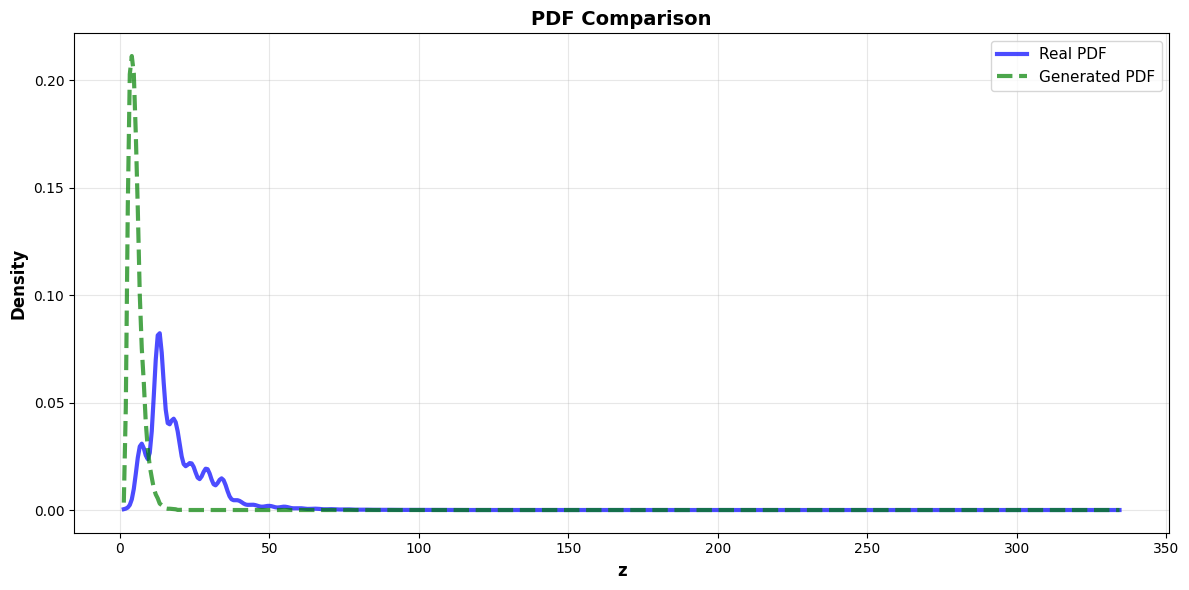

In [8]:
kde_real = gaussian_kde(z)
kde_fake = gaussian_kde(z_fake)

x_range = np.linspace(min(z.min(), z_fake.min()), max(z.max(), z_fake.max()), 500)
pdf_real = kde_real(x_range)
pdf_fake = kde_fake(x_range)

plt.figure(figsize=(12, 6))
plt.plot(x_range, pdf_real, 'b-', linewidth=3, label='Real PDF', alpha=0.7)
plt.plot(x_range, pdf_fake, 'g--', linewidth=3, label='Generated PDF', alpha=0.7)
plt.xlabel('z', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold')
plt.title('PDF Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()